## Estimate Home Values in Zillow

Faith Kane
10/18/2019

### Goals:

1. Use the fips numbers in the Zillow database to identify the locations of the properties I am examining.

2. Use the tax amounts and actual home values to show the distribution of tax rates for each county I identify in my data. 

3. Build a linear regression model that predicts home values using three features: bedroom count, bathroom count, and square feet.

4. Evaluate and compare the metrics from my model to a baseline model that predicts home values using only the mean of all home values. I will use the $R2$ values of the models to decide if my linear regression model with the three identified features from above is able to make more accurate predictions.

5. Iterate through the modeling and evaluation stages again using only one feature, square feet of the home, to predict the home value and decide if it is more or less accurate than using the original three features from above. 

### Import Modules:

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


import env
import util
import wrangle_zillow
import split_scale_zillow
import features_zillow
import model_zillow

#### Read In, Clean, and Transform the Data Using wrangle_zillow()

-My function, wrangle_zillow, uses the SQL query I created to bring in data from the Zillow database, drop rows containing Null values, and set my columns to the appropriate data types.

-My SQL query filtered the Zillow data to include only single unit residential properties whose last transactions were in the months of May and June in 2017. I also filtered out any rows that had a value of zero for bedroomcnt or bathroomcnt which gave me a row count of 15,947.

-I adjusted my SQL query to filter out any rows that had a value below one or above six for bedrooms or a value below one or above five for bathrooms which gave me a total of 15,722 rows to work with in my models. I based my decision for the upper bounds on bedrooms and bathrooms on the equation Q3 + 1.5 * IQR. However, when I ran my models, the $R^2$ scores went down by more than ten percent, so I decided to leave in the outliers and use my original SQL query from above.

In [2]:
df = wrangle_zillow.wrangle_zillow()

#### Summarize the Data Using tell_me_about(df)

-My function, tell_me_about(df), allows me to view important descriptive information about my data before I begin to work with it. 

In [3]:
util.tell_me_about(df)

DataFrame Shape:

(15947, 8)

Info about:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15947 entries, 0 to 15955
Data columns (total 8 columns):
bedrooms               15947 non-null float64
bathrooms              15947 non-null float64
square_feet            15947 non-null int64
taxes                  15947 non-null float64
home_value             15947 non-null float64
propertylandusedesc    15947 non-null category
fips_number            15947 non-null int64
zip_code               15947 non-null category
dtypes: category(2), float64(4), int64(2)
memory usage: 931.8 KB
None

Describe:

           bedrooms     bathrooms   square_feet          taxes    home_value  \
count  15947.000000  15947.000000  15947.000000   15947.000000  1.594700e+04   
mean       3.253026      2.215213   1836.276729    5680.471976  4.632920e+05   
std        0.949431      1.025248    980.727638    7466.513817  6.434062e+05   
min        1.000000      1.000000    320.000000      49.180000  1.216800e+04   
2

#### Create a Field that Calculates the Tax Rate:

In [4]:
df["tax_rate"] = df["taxes"] / df["home_value"]
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073


#### Add the county name to the DataFrame based on the fips number.

In [5]:
df["county_name"] = df["fips_number"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


### Create Distributions of the Tax Rates by County:

In [6]:
df.groupby("county_name").tax_rate.mean()
df.groupby("county_name").tax_rate.count()
#county_df = 

county_name
Los Angeles    12382
Orange          2778
Ventura          787
Name: tax_rate, dtype: int64

In [7]:
df.groupby("zip_code").zip_code.count()

zip_code
95982.0      29
95983.0      47
95984.0      51
95985.0      39
95986.0       8
95987.0       5
95988.0      11
95989.0      43
95992.0      34
95993.0       5
95994.0       1
95997.0      55
95999.0      41
96000.0      36
96001.0       3
96003.0      56
96004.0      22
96005.0      23
96006.0      19
96007.0      51
96008.0      29
96009.0       6
96010.0      13
96012.0      29
96013.0      55
96014.0      18
96015.0      51
96016.0      28
96017.0      23
96018.0      27
96019.0       6
96020.0      46
96021.0      14
96022.0      62
96023.0      69
96024.0      92
96025.0      78
96026.0      89
96027.0      64
96028.0      95
96029.0      24
96030.0      68
96037.0      24
96038.0       3
96039.0       2
96040.0      32
96042.0      38
96043.0      37
96044.0      47
96045.0      64
96046.0      71
96047.0     105
96049.0      52
96050.0      21
96058.0      27
96083.0      29
96086.0      67
96087.0       7
96088.0      10
96090.0      80
96091.0      71
96092.0      47

### Correlation Test

In [8]:
df.corr()

,bedrooms,bathrooms,square_feet,taxes,home_value,fips_number,tax_rate
bedrooms,1.000000,0.657402,0.621797,0.272215,0.279147,0.130339,-0.090935
bathrooms,0.657402,1.000000,0.846623,0.519509,0.535530,0.088470,-0.149872
square_feet,0.621797,0.846623,1.000000,0.611819,0.638991,0.092985,-0.162766
taxes,0.272215,0.519509,0.611819,1.000000,0.977952,-0.007645,-0.143307
home_value,0.279147,0.535530,0.638991,0.977952,1.000000,0.018059,-0.208675
fips_number,0.130339,0.088470,0.092985,-0.007645,0.018059,1.000000,-0.177635
tax_rate,-0.090935,-0.149872,-0.162766,-0.143307,-0.208675,-0.177635,1.000000


### T-Test

In [9]:
df.groupby("bedrooms").bedrooms.count()
df.groupby("bathrooms").bathrooms.count()

bathrooms
1.0     3455
1.5      173
2.0     7117
2.5      688
3.0     3161
3.5      130
4.0      656
4.5      108
5.0      263
5.5       33
6.0       90
6.5        5
7.0       46
7.5        2
8.0        5
9.0        7
10.0       5
11.0       1
19.5       1
20.0       1
Name: bathrooms, dtype: int64

#### Split the Data Using split_my_data(df) and Assign Features (x) and Target (y)

-I split my data using a function I created that creates a train set using 80% of the data and a test set using 20%. I used the random seed "123" in splitting my data.

-The features I am using to predict "taxvaluedollarcnt"in my x_train and x_test dataframes are the "bedroomcnt", "bathroomcnt", and "calculatedfinishedsquarefeet" fields from the Zillow database.

-The feature I am using to predict "taxvaluedollarcnt" in my s_train and s_test dataframes is "calculatedfinishedsquarefeet" from the Zillow database.

In [10]:
train, test = split_scale_zillow.split_my_data(df)

#####  Assign x_train x_test to the three features of bedrooms, bathrooms, and square feet and y_train and y_test to the target of home_value

In [11]:
x_train = train[["bedrooms", "bathrooms", "square_feet"]]
y_train = train[["home_value"]]
x_test = test[["bedrooms", "bathrooms", "square_feet"]]
y_test = test[["home_value"]]

#####  Assign sbd_train sbd_test to the features of square feet and bedrooms

In [12]:
sbd_train = train[["square_feet", "bedrooms"]]
sbd_test = test[["square_feet", "bedrooms"]]

#####  Assign sbt_train sbt_test to the features of square feet and bathrooms

In [13]:
sbt_train = train[["square_feet", "bathrooms"]]
sbt_test = test[["square_feet", "bathrooms"]]

#### Scale the Data Using the Standard Scaler

-I used the iqr_robust_scaler to scale my x_train, x_test and s_train, s_test data because it scales features using stats that are robust to outliers by removing the median and scaling data to the IQR.

In [14]:
scaler, x_train_scaled, x_test_scaled = split_scale_zillow.iqr_robust_scaler(x_train, x_test)
x_train = x_train_scaled
x_test = x_test_scaled
x_train.head()
x_test.head()

,bedrooms,bathrooms,square_feet
5402,1.0,1.0,0.583696
15625,-1.0,0.0,-0.691304
5300,0.0,0.0,-0.179348
11455,0.0,0.0,0.238043
8110,0.0,0.0,-0.052174


In [15]:
scaler, sbd_train_scaled, sbd_test_scaled = split_scale_zillow.iqr_robust_scaler(sbd_train, sbd_test)

In [16]:
scaler, sbt_train_scaled, sbt_test_scaled = split_scale_zillow.iqr_robust_scaler(sbt_train, sbt_test)

#### Feature Selection:

-I used my function optimal_number_of_features function to find out the optimal number of features to feed into my Linear Regression model and the $R^2$ value using those features. The recommendation was that the three features together would predict my target value with a $R^2$ of .4406.

-Using the three features together rather than the other combinations I tried below, square_feet and bathrooms or square_feet and bedrooms, returned the highest $R^2$ value, and thus is the combination of features I will use in my Linear Regression model to predict home values.


In [17]:
features_zillow.optimal_number_of_features(x_train_scaled, y_train)

(3, 0.4406039047470966)

In [18]:
features_zillow.optimal_number_of_features(sbd_train_scaled, y_train)

(2, 0.4393605165369422)

In [19]:
features_zillow.optimal_number_of_features(sbt_train_scaled, y_train)

(2, 0.4160258684955639)

#### Explore the Data: 

-I used a Pair Grid to visualize the correlation between features.

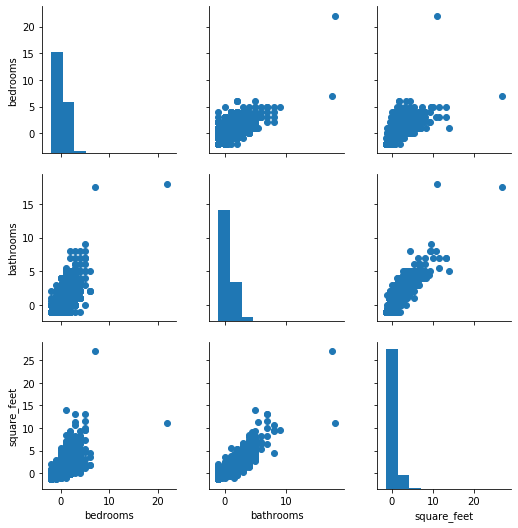

In [20]:
g = sns.PairGrid(x_train_scaled)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Model:  Create Linear Regression Models Using modeling_function()

-I used my modeling_function() to create a dataframe containing the actual home values, the predictions made by my Linear Regression Model 1, lm1, that used the original three features of bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet to predict the target value, and the baseline model or mean of all target property values.

-I created a Linear Regression Model 2, lm2, that predicted the target home values using only the feature of calculatedfinishedsquarefeet. I added those values to the predictions dataframe for use in creating and evaluating the metrics of the models and finding which was most useful in our goal of predicting home values.

In [21]:
predictions, predictions_test = model_zillow.modeling_function(x_train_scaled, y_train, x_test_scaled, y_test)
predictions.head()
#predictions_test.head()

,actual,lm1,lm_baseline
0,1252995.0,885428.134588,461061.036921
1,192960.0,279014.832467,461061.036921
2,616795.0,753196.413153,461061.036921
3,470103.0,631875.015836,461061.036921
4,361585.0,310014.300220,461061.036921


#### Evaluate:  Compare Model Performance Metrics

The Baseline Model Evaluation Metrics:

-The baseline model evaluation reveals an $R^2$ value of 0. I will use this value to compare with the $R^2$ values of my train and test linear regression models below. I want to find out if the models can predict home values better than just using the mean of all the home values.

In [22]:
MSE_baseline = mean_squared_error(predictions.actual, predictions.lm_baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.lm_baseline)
baseline_metrics_df = pd.DataFrame(np.array(["MSE_baseline", "SSE_baseline","RMSE_baseline", "R2_baseline"]), columns=["metric"])
baseline_metrics_df["value"] = np.array([MSE_baseline, SSE_baseline, RMSE_baseline, r2_baseline])
baseline_metrics_df

,metric,value
0,MSE_baseline,4.080999e+11
1,SSE_baseline,5.206131e+15
2,RMSE_baseline,6.388270e+05
3,R2_baseline,0.000000e+00


The Linear Regression Models' Evaluation Metrics:

-The Linear Regression model including bedrooms, bathrooms, and square_feet as features returned a $R^2$ value of .4406 for the train data set and .4029 for the test data set.


In [33]:
MSE_1= mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print(MSE_1,SSE_1,RMSE_1,r2_1)

228289509754.3348 2912289275936049.0 477796.51500857016 0.44060390474709654


In [31]:
MSE_lm1_test = mean_squared_error(predictions_test.actual, predictions_test.lm1_test)
SSE_lm1_test = MSE_lm1_test*len(predictions_test.actual)
RMSE_lm1_test = sqrt(MSE_lm1_test)
r2_lm1_test = r2_score(predictions_test.actual, predictions_test.lm1_test)
print(MSE_lm1_test,SSE_lm1_test,RMSE_lm1_test,r2_lm1_test)

261026036471.9538 832673056345532.6 510907.07224695355 0.40299158716244654


#### Side-by-Side Comparison of Model Evaluation Metrics:

In [ ]:
df_eval = pd.DataFrame(np.array(["SSE","MSE","RMSE", "R2"]), columns=["metric"])
df_eval["model_1_error"] = np.array([SSE_1, MSE_1, RMSE_1, r2_1])
df_eval["baseline_error"] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline])
df_eval["error_delta_1"] = df_eval.model_1_error - df_eval.baseline_error
df_eval

In [ ]:
df_eval_test = pd.DataFrame(np.array(["SSE","MSE","RMSE", "R2"]), columns=["metric"])
df_eval_test["lm1_test_error"] = np.array([SSE_lm1_test, MSE_lm1_test, RMSE_lm1_test, r2_lm1_test])
df_eval_test["baseline_error"] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline])
df_eval_test["error_delta_lm1_test"] = df_eval_test.lm1_test_error - df_eval_test.baseline_error

df_eval_test